1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [15]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'data/data_000637.txt'
column_names = ['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']
N = 15000
data = pd.read_csv(file_path, delimiter=',', names=column_names, nrows=N)
data = data.iloc[1:]
data.reset_index(drop=True, inplace=True)

print(data.head())
columns_to_convert = ['ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric)

  HEAD FPGA TDC_CHANNEL   ORBIT_CNT BX_COUNTER TDC_MEAS
0    1    0         123  3869200167       2374       26
1    1    0         124  3869200167       2374       27
2    1    0          63  3869200167       2553       28
3    1    0          64  3869200167       2558       19
4    1    0          64  3869200167       2760       25


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [17]:
max_bx_counter = data['BX_COUNTER'].max()

print(f"The maximum value of BX_COUNTER before reset is: {max_bx_counter}")

The maximum value of BX_COUNTER before reset is: 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [18]:
condition = data['BX_COUNTER'] != 0
data['Absolute_Time'] = np.where(condition,
                                 data['ORBIT_CNT'] * data['BX_COUNTER'] * 25 + data['TDC_MEAS'] * (30 / 25),
                                 data['ORBIT_CNT'] + data['TDC_MEAS'] * (30 / 25))

start_time = data['Absolute_Time'].min()

print(data.head())

  HEAD FPGA TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  Absolute_Time
0    1    0         123  3869200167        2374        26   2.296370e+14
1    1    0         124  3869200167        2374        27   2.296370e+14
2    1    0          63  3869200167        2553        28   2.469517e+14
3    1    0          64  3869200167        2558        19   2.474354e+14
4    1    0          64  3869200167        2760        25   2.669748e+14


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [19]:
max_time = data['Absolute_Time'].max()
min_time = data['Absolute_Time'].min()

duration_ns = max_time - min_time

duration_seconds = duration_ns / 1e9 
hours = duration_seconds // 3600
minutes = (duration_seconds % 3600) // 60
seconds = duration_seconds % 60

print(f"Duration of data taking: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

Duration of data taking: 95 hours, 44 minutes, 5.15 seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [20]:
top_channels = data['TDC_CHANNEL'].value_counts().sort_values(ascending=False)

print("Top 3 Noisy Channels:")
for channel, count in top_channels.head(3).items():
    print("Channel", channel, ": Count", count)

Top 3 Noisy Channels:
Channel 139 : Count 1267
Channel 64 : Count 752
Channel 63 : Count 749


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [21]:
non_empty_orbits = len(data[data['TDC_MEAS'] > 0])
print("Number of non-empty orbits:", non_empty_orbits)

Number of non-empty orbits: 13311


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [22]:
tdc_channel_139 = data[data['TDC_CHANNEL'] == '139']
unique_orbits = tdc_channel_139['ORBIT_CNT'].nunique()
print("Number of unique orbits with TDC_CHANNEL=139:", unique_orbits)

Number of unique orbits with TDC_CHANNEL=139: 150


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [23]:
fpga_0_data = data[data['FPGA'] == '0']
fpga_1_data = data[data['FPGA'] == '1']

fpga_0_counts = fpga_0_data['TDC_CHANNEL'].value_counts()
fpga_1_counts = fpga_1_data['TDC_CHANNEL'].value_counts()

fpga_0_series = pd.Series(fpga_0_counts.values, index=fpga_0_counts.index, name='FPGA_0_Counts')
fpga_1_series = pd.Series(fpga_1_counts.values, index=fpga_1_counts.index, name='FPGA_1_Counts')

print("Series for FPGA 0:")
print(fpga_0_series.tail())

print("\nSeries for FPGA 1:")
print(fpga_1_series.head())


Series for FPGA 0:
TDC_CHANNEL
99     5
107    5
98     5
106    4
101    3
Name: FPGA_0_Counts, dtype: int64

Series for FPGA 1:
TDC_CHANNEL
139    389
2      363
1      338
4      290
3      277
Name: FPGA_1_Counts, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

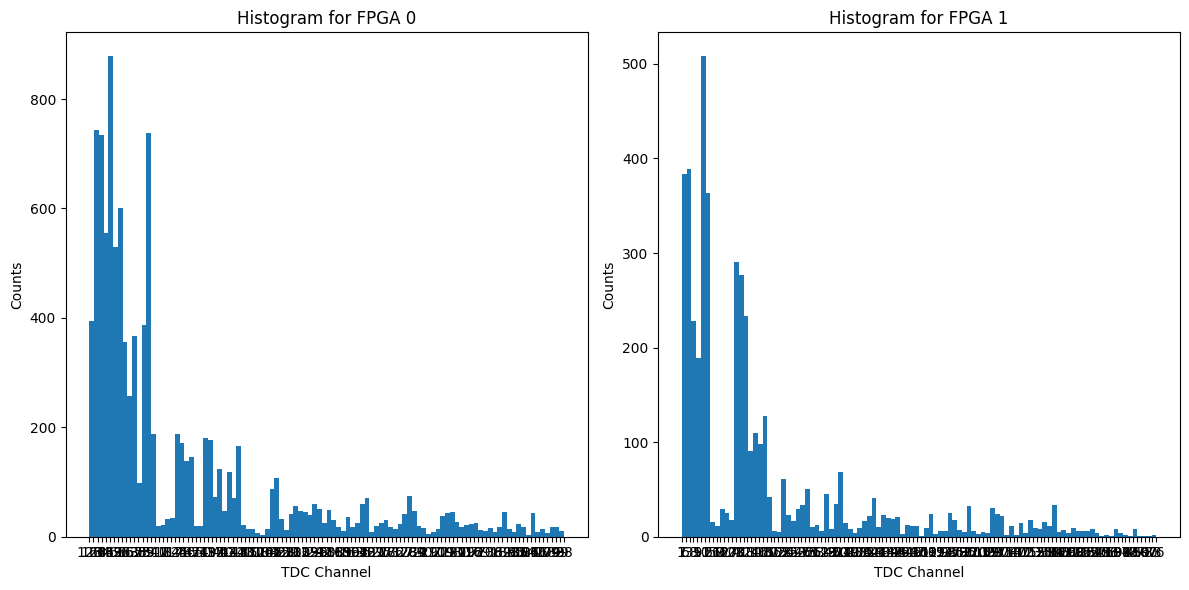

In [24]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fpga_0_data['TDC_CHANNEL'],bins=100)
plt.title('Histogram for FPGA 0')
plt.xlabel('TDC Channel')
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
plt.hist(fpga_1_data['TDC_CHANNEL'],bins=100)
plt.title('Histogram for FPGA 1')
plt.xlabel('TDC Channel')
plt.ylabel('Counts')

plt.tight_layout()
plt.show()